## 6 years of historical data for Statistical Analysis of Cryptocurrencies

Pivoting towards Cryptocurrencies analysis as per feedback from previous submissions, we are focusing on 3 major crytocurrencies for the past 6 years, which will sufficiently cover various market regimes and extreme volatility.
1. Considering crypto data from Nov 2017 to Nov 2023
2. Considered:
  - BTC ~ Bitcoin
  - ETH ~ Ethereum
  - BNB ~ Binance
3. Chow Test
4. Regime Detection
5. Clustering
6. GMM
7. HMM
8. MSM

https://colab.research.google.com/drive/1ySJRBDqYsLlZ6k08cnyAm-Sj3zZXbGEx?usp=sharing

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import statsmodels.api as sm

!pip install hmmlearn
import numpy as np
from hmmlearn.hmm import GaussianHMM
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import math
import warnings

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
warnings.filterwarnings('ignore')

!pip install "git+https://github.com/lopatovsky/HMMs.git" --quiet
import hmms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00


### Defining the list of tickers we want to work with, and the time range

In [ ]:
start_date = "2017-11-09"
end_date = "2023-11-13"

cryptos_list = [
    "BTC-USD", # bitcoin
    "ETH-USD", # ethereum
    "BNB-USD", # binance
]

### Function to download fin data, and visualize data

In [ ]:
def download_financial_data(symbol_list, start=start_date, end=end_date):
  """ function to download financial data using yfinance """
  data = yf.download(symbol_list, start=start, end=end)
  return data["Adj Close"]


def plot_prices(data, title="", big=True):
  """ Plot closing prices """
  data.plot(title=title, figsize=(15, 10) if big else (8, 5))
  plt.ylabel('Price')
  plt.show()

### Extract the data

In [ ]:
cryptos = download_financial_data(cryptos_list)

assets = pd.concat([cryptos], axis=1)
assets = assets.dropna()
assets.tail()

[*********************100%%**********************]  3 of 3 completed


,BNB-USD,BTC-USD,ETH-USD
Date,,,
2023-11-08,247.123291,35655.277344,1889.322388
2023-11-09,251.510849,36693.125000,2120.561035
2023-11-10,251.082367,37313.968750,2078.289795
2023-11-11,251.421616,37138.050781,2052.713867
2023-11-12,247.640015,37054.519531,2045.187012


Summary Statistics

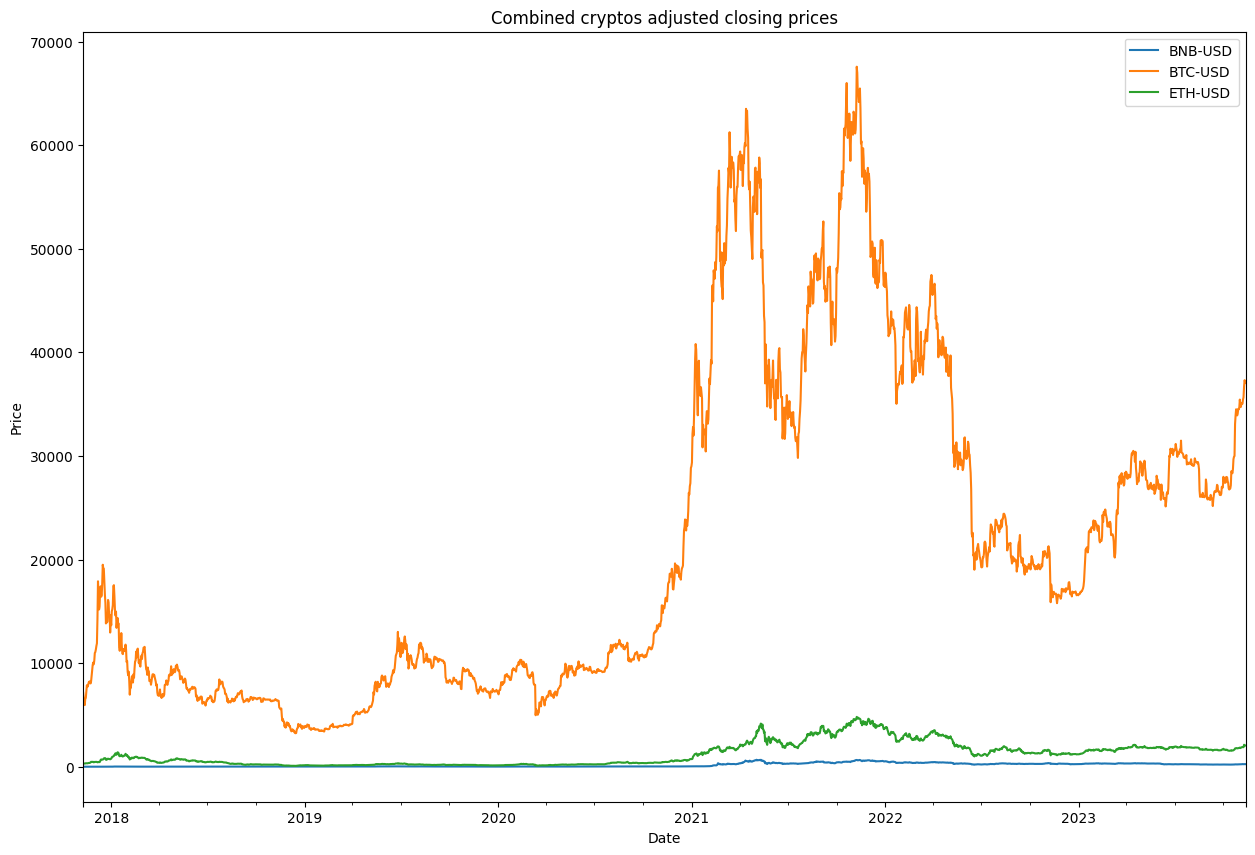

In [ ]:
plot_prices(cryptos, "Combined cryptos adjusted closing prices")

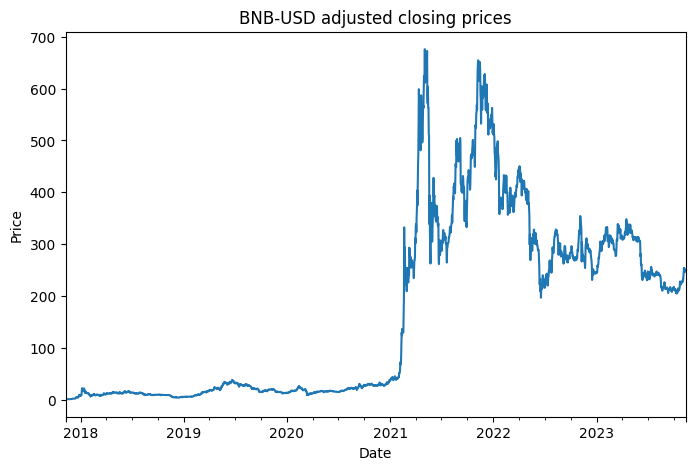

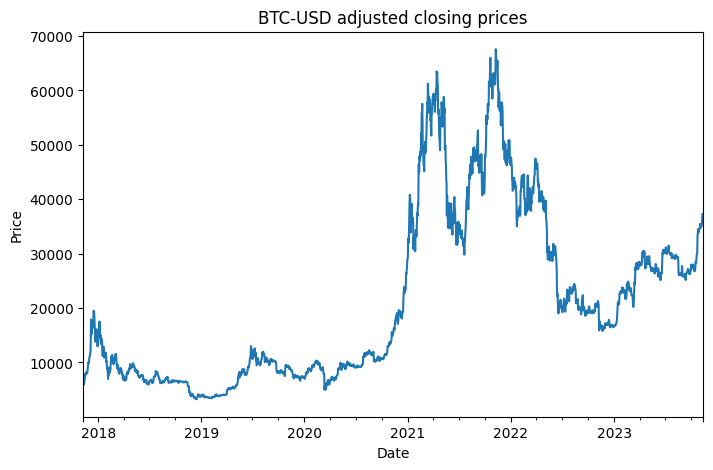

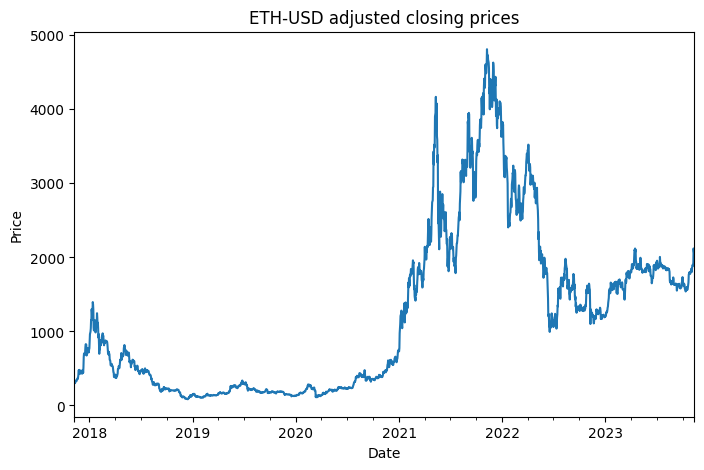

In [ ]:
# Plot all Adjusted closing prices of the 3 cryptos
for crypto in cryptos:
  data = assets[crypto]
  plot_prices(data, f"{crypto} adjusted closing prices", big=False)

In [ ]:
# Daily returns
returns = assets.pct_change().dropna()

# Summary stats
print("Summary Statistics:")
print(returns.describe())

Summary Statistics:
           BNB-USD      BTC-USD      ETH-USD
count  2194.000000  2194.000000  2194.000000
mean      0.003732     0.001476     0.002002
std       0.056655     0.037906     0.047730
min      -0.419046    -0.371695    -0.423472
25%      -0.018877    -0.014427    -0.019373
50%       0.000983     0.000830     0.000735
75%       0.023931     0.017002     0.024219
max       0.697604     0.252472     0.264581


In [ ]:
# Annualized volatility
vol = returns.std() * np.sqrt(252)
vol_percentage = vol * 100.0
print(vol_percentage)

BNB-USD    89.937699
BTC-USD    60.174073
ETH-USD    75.768247
dtype: float64


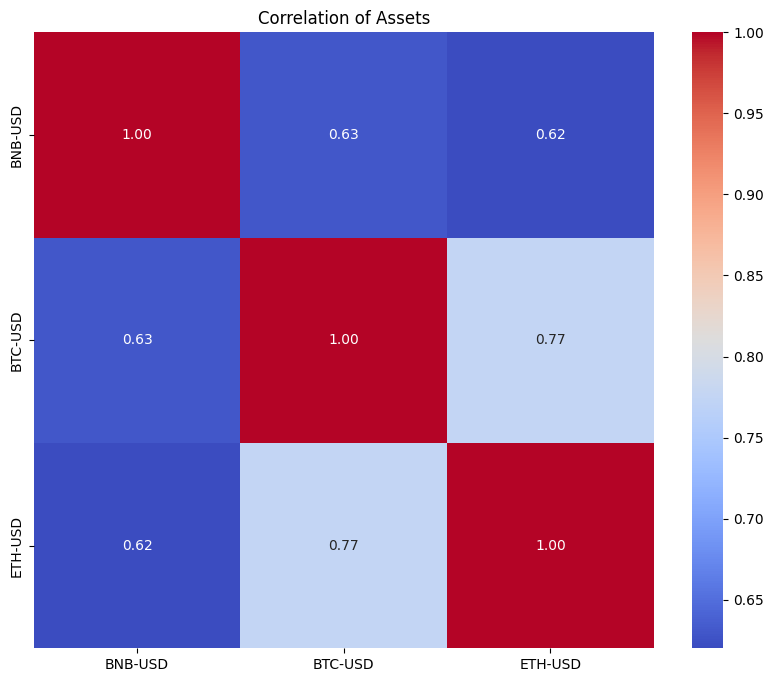

In [ ]:
# Correlation matrix
corr = returns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Assets')
plt.show()

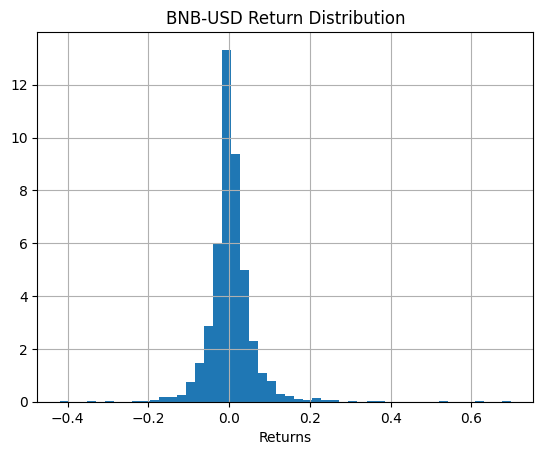

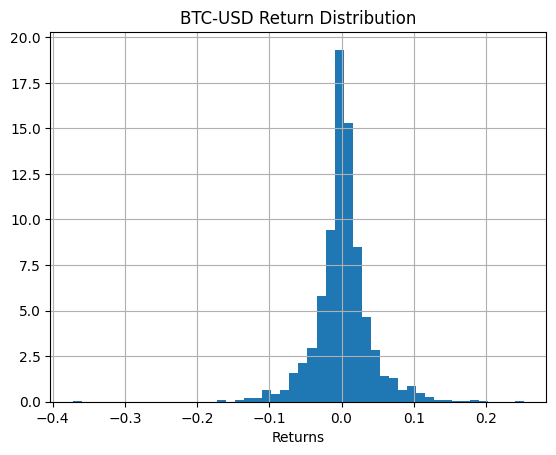

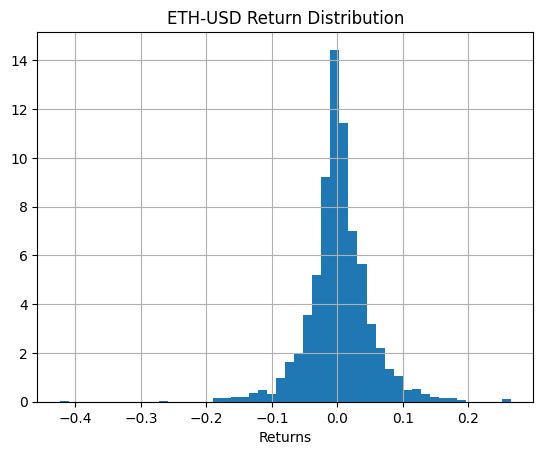

In [ ]:
# Distribution plots
for col in assets.columns:
    returns[col].hist(bins=50, density=True)
    plt.xlabel('Returns')
    plt.title(f'{col} Return Distribution')
    plt.show()

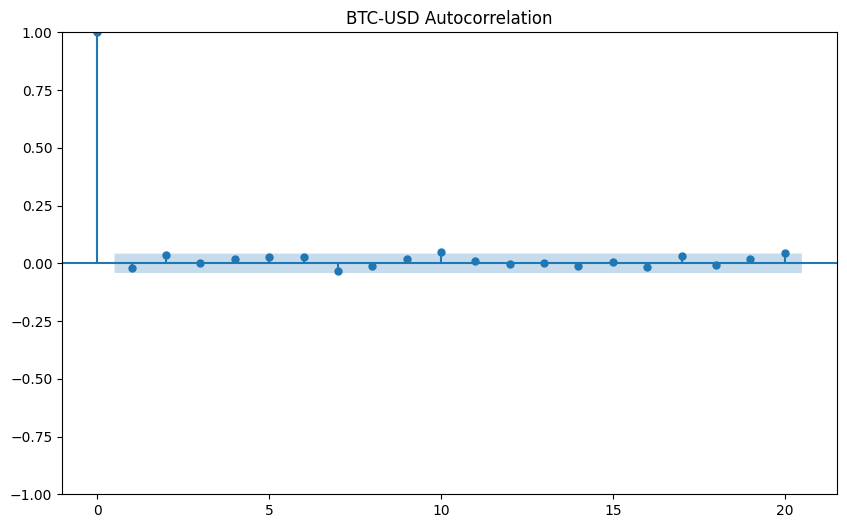

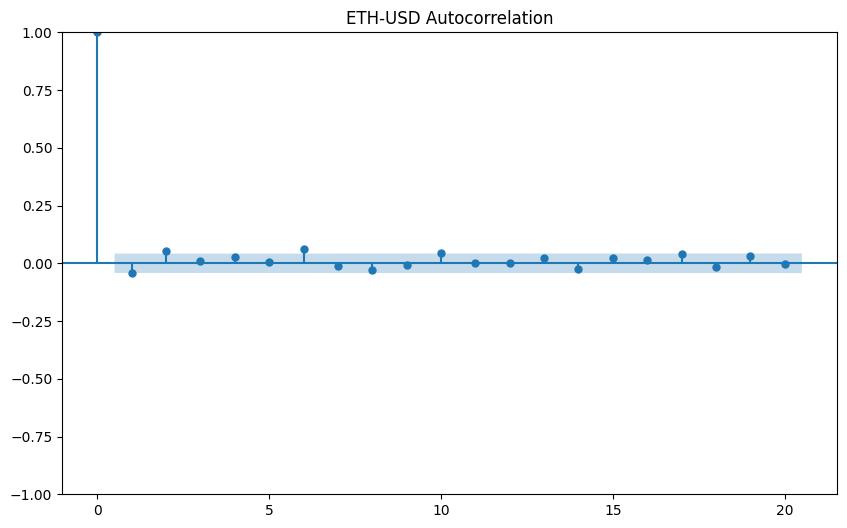

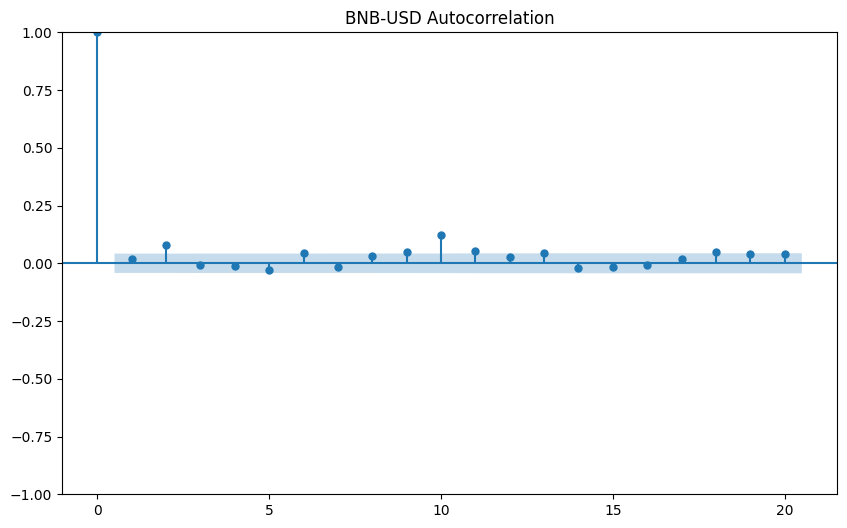

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation
def plot_autocorrelation(data, title="", lag=20):
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_acf(data, lags=lag, ax=ax)  # Import the plot_acf function
    ax.set_title(title)
    plt.show()

# Calculate and plot autocorrelation for each cryptocurrency
for crypto in cryptos_list:
    crypto_returns = returns[crypto]
    plot_autocorrelation(crypto_returns, f"{crypto} Autocorrelation", lag=20) # upto lag of 20 days

# Peaks in the autocorrelation plot suggests potential patterns or dependencies at specific lags.

Skewness and Kurtosis

In [ ]:
from scipy.stats import skew, kurtosis

# Check for NaN values in returns
if returns.isnull().values.any():
    print("Warning: NaN values detected in returns. Removing rows with NaN.")
    returns = returns.dropna()

# Skewness and kurtosis
skewness = skew(returns)
kurt = kurtosis(returns)

print("\nSkewness:")
print(skewness)

print("\nKurtosis:")
print(kurt)


Skewness:
[ 2.02174048 -0.12613035 -0.21650773]

Kurtosis:
[25.06967797  7.79027473  5.99607921]


Skewness:
BNB-USD Skewness is positive (2.02) suggesting positively skewed distribution of daily returns i.e. tendency for larger positive returns than would be expected in a normal distribution.

BTC-USD Skewness is close to zero (-0.13). Distribution of daily returns is approximately symmetric. No strong skewness towards positive or negative returns.

ETH-USD Skewness is slightly negative (-0.22) suggest a mild negative skewness, that is a slight tendency for more negative returns than would be expected in a normal distribution.

Kurtosis:
BNB-USD is high (25.07). A high kurtosis value indicates heavy tails and a more peaked distribution compared to a normal distribution. Note - This could imply  extreme events (large positive or negative returns) are more likely than in a normal distribution. We will check on this in our analysis

BTC-USD moderate (7.79). Higher than the kurtosis of a normal distribution (which is 3), it's not as extreme BNB. That means BTC returns have relatively fatter tails and a more peaked distribution than normal.

ETH-USD moderate (6.00). Returns have a distribution with fatter tails and a more peaked shape compared to a normal distribution.


BNB-USD exhibits the highest skewness and kurtosis, indicating a distribution with a higher likelihood of extreme returns. BTC-USD and  ETH-USD show more symmetric distributions with milder deviations from normality

**Chow Test**

In [ ]:
import statsmodels.api as sm

# Choosing 'BTC-USD' stock data for the analysis
imnt = 'BTC-USD'

nobs = len(assets[imnt])
time_points = np.arange(nobs)

# Define a potential break point
break_point = 150  # Specifying a single break point to check

# Split the data into two parts based on the break point
data_1 = assets[imnt].iloc[:break_point]
data_2 = assets[imnt].iloc[break_point:]

# Fit linear models to both parts
model_1 = sm.OLS(data_1, sm.add_constant(time_points[:break_point])).fit()
model_2 = sm.OLS(data_2, sm.add_constant(time_points[break_point:])).fit()

# Calculate Chow test statistic
RSS_total = (model_1.ssr + model_2.ssr)
model_combined = sm.OLS(assets[imnt], sm.add_constant(time_points)).fit()
RSS_combined = model_combined.ssr

numerator = (RSS_combined - RSS_total) / 2
denominator = RSS_total / (nobs - 4)  # nobs - 4 is the degrees of freedom for the full model

F_statistic = numerator / denominator

# Print the Chow test result
print(f"Chow test statistic: {F_statistic}")

# Chow test statistic: 133.3250127298603 (break point 125)

Chow test statistic: 19.285135333246455


## Regime Detection

In [ ]:
# Slice out the data of bitcoin from the central assets to work on regime detection
asset_btc = assets['BTC-USD'].dropna()
asset_btc_diff = asset_btc.pct_change(1)
asset_btc_diff

Date
2017-11-09         NaN
2017-11-10   -0.073554
2017-11-11   -0.039368
2017-11-12   -0.064101
2017-11-13    0.102422
                ...   
2023-11-08    0.005973
2023-11-09    0.029108
2023-11-10    0.016920
2023-11-11   -0.004715
2023-11-12   -0.002249
Name: BTC-USD, Length: 2195, dtype: float64

In [ ]:
# Use the Hidden Markov Models and Viterbi to compute estimations
btc_base_seq = np.array(asset_btc_diff.apply(lambda x: 1 if x > 0 else 0).values)
dhmm_r = hmms.DtHMM.random(3, 2)
seq = np.array_split(btc_base_seq, 32)

dhmm_r.baum_welch(seq, 6)
# hmms.print_parameters(dhmm_r) # print the parameters from the baum welch algo compute

(log_prob, btc_seq) = dhmm_r.viterbi(np.concatenate(seq).ravel())

iteration  1 / 6
iteration  2 / 6
iteration  3 / 6
iteration  4 / 6
iteration  5 / 6
iteration  6 / 6


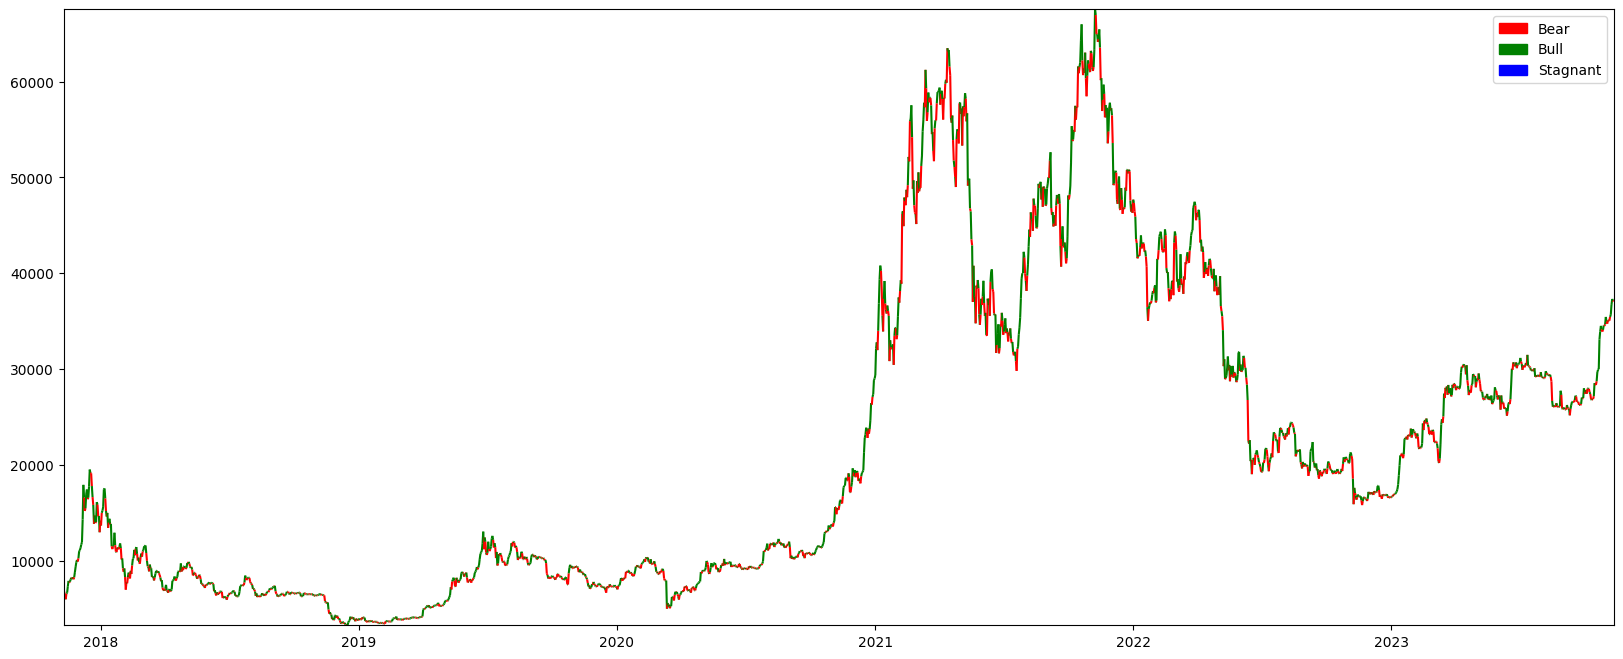

In [ ]:
def plot_regime_detection(price_plot, segments):
  """ function to plot the regime detection data """
  fig, ax1 = plt.subplots(figsize=(20, 8))
  color_map = ListedColormap(['r', 'b', 'g'], 'indexed')
  norm = BoundaryNorm(range(3 + 1), color_map.N)

  line_collection = LineCollection(segments, cmap=color_map, norm=norm)
  line_collection.set_array(price_plot['Regime'])
  plt.gca().add_collection(line_collection)
  plt.xlim(price_plot[datapoint].index.min(), price_plot[datapoint].index.max())
  plt.ylim(price_plot[datapoint].min(), price_plot[datapoint].max())

  r_patch = mpatches.Patch(color='red', label='Bear')
  g_patch = mpatches.Patch(color='green', label='Bull')
  b_patch = mpatches.Patch(color='blue', label='Stagnant')

  plt.legend(handles=[r_patch, g_patch, b_patch])
  plt.show()

# data frame data extraction for plotting
price_plot = pd.DataFrame(asset_btc, index=asset_btc.index)
price_plot['Regime'] = btc_seq
price_plot['diff'] = asset_btc_diff[1:]
datapoint = "BTC-USD"

# compute mean based on the Regime and the diff column
means = price_plot.groupby(['Regime'])['diff'].mean()
means_index = means.index.tolist()
means_index_sorted = means.sort_values().index.tolist()

map_regimes = dict(zip(means_index_sorted, means_index))
price_plot['Regime'] = price_plot['Regime'].map(map_regimes)

inxval = mdates.date2num(price_plot[datapoint].index.to_pydatetime())
points = np.array([inxval, price_plot[datapoint]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# plot
plot_regime_detection(price_plot, segments)


In [ ]:
class RegimeDetection:

  def get_regimes_hmm(self, input_data, params):
    """ create and use the model driven by the Hidden Markov Model """
    return self.initialise_model(GaussianHMM(), params).fit(input_data)

  def get_regimes_clustering(self, params):
    """ create and use the model driven by Agglomerative clustering """
    return self.initialise_model(AgglomerativeClustering(), params)

  def get_regimes_gmm(self, input_data, params):
    """ create and use the model driven by the Gaussian Mixture Model """
    return self.initialise_model(GaussianMixture(), params).fit(input_data)

  def initialise_model(self, model, params): # helper method for the model initialization
    for parameter, value in params.items():
      setattr(model, parameter, value)
    return model

In [ ]:
def plot_hidden_states(hidden_states, prices_df, columns, title=None):
    """
    Inputs:
    - hidden_states(numpy.ndarray): array of predicted hidden states
    - prices_df(df): dataframe of close prices
    - columns: the column name of the prices in the dataframe
    - title(str, optional): Title of the plot. Defaults to None.

    Outputs:
    - Graph showing hidden states and prices
    """

    colors = ['blue', 'red', 'green', 'yellow', 'purple']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()
    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State ', i, ":", len(prices_df.index[mask]))

        fig.add_trace(go.Scatter(x=prices_df.index[mask], y=prices_df[columns][mask],
                    mode='markers', name='Hidden State ' + str(i), marker=dict(size=4, color=colors[i])))

    # Update layout to include title if provided
    fig.update_layout(
        title=dict(text=title, font_size=13), title_x=0.5,
        height=400, width=900,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        margin=dict(l=20, r=20, t=20, b=20)
    ).show()

In [ ]:
def prepare_data_for_model_input(prices, intrument, ma):
   """
       Input:
       prices (df) - Dataframe of close prices
       ma (int) - legth of the moveing average

       Output:
       prices(df) - An enhanced prices dataframe, with moving averages and log return columns
       prices_array(nd.array) - an array of log returns
   """

   prices[f'{intrument}_ma'] = prices[intrument].rolling(ma).mean()
   prices[f'{intrument}_log_return'] = np.log(prices[f'{intrument}_ma']/prices[f'{intrument}_ma'].shift(1)).dropna()
   prices.dropna(inplace = True)

   return prices

In [ ]:
def get_segment_statistics(data):
  series = pd.Series(data)
  groups = series[series != series.shift()].index

  # Append the length of the series to handle the last group
  groups = list(groups) + [len(series)]

  # Calculate the length of each segment
  lengths = [groups[i] - groups[i - 1] for i in range(1, len(groups))]

  # get min, median, max, average
  min_length = min(lengths)
  median_length = pd.Series(lengths).median()
  max_length = max(lengths)
  average_length = sum(lengths) / len(lengths)
  return min_length, median_length, max_length, average_length

### Find the optimal moving average

Because the only parameter for the three models is the number of regime, which is set at 3, as we hope to divide the regimes into bear/bull/stagnant. Therefore, the moving average to use determines the model outcomes. In the section below, we evaluated the min, median, max and average durations for each regime segment, against different moving averages.

In [ ]:
ma_ = []
model_ = []
min_ = []
median_ = []
max_ = []
average_ = []
crypto_ = []

regime_detection = RegimeDetection()
params = {'n_clusters': 3, 'linkage': 'complete', 'metric': 'manhattan', 'random_state':100}
clustering = regime_detection.get_regimes_clustering(params)

params1 = {'n_components':3, 'covariance_type': 'full', 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
params2 = {'n_components':3, 'covariance_type':"full", 'random_state':100}

for ma in range(7, 31): # running moving average calculation from 7 to 30
  for crypto in cryptos:
    assets1 = assets
    assets1 = prepare_data_for_model_input(assets1, crypto, ma)
    # FOR CLUSTERING

  # BTC
  prices_array_BTC = np.array([[q] for q in assets1['BTC-USD_log_return'].values])
  clustering_states = clustering.fit_predict(prices_array_BTC)
  min_length, median_length, max_length, average_length = get_segment_statistics(clustering_states)
  ma_.append(ma)
  model_.append("Clustering")
  crypto_.append("BTC-USD")
  min_.append(min_length)
  median_.append(median_length)
  max_.append(max_length)
  average_.append(average_length)

  # BNB
  prices_array_BNB = np.array([[q] for q in assets1['BNB-USD_log_return'].values])
  clustering_states = clustering.fit_predict(prices_array_BNB)
  min_length, median_length, max_length, average_length = get_segment_statistics(clustering_states)
  ma_.append(ma)
  model_.append("Clustering")
  crypto_.append("BNB-USD")
  min_.append(min_length)
  median_.append(median_length)
  max_.append(max_length)
  average_.append(average_length)

  # ETH
  prices_array_ETH = np.array([[q] for q in assets1['ETH-USD_log_return'].values])
  clustering_states = clustering.fit_predict(prices_array_ETH)
  min_length, median_length, max_length, average_length = get_segment_statistics(clustering_states)
  ma_.append(ma)
  model_.append("Clustering")
  crypto_.append("ETH-USD")
  min_.append(min_length)
  median_.append(median_length)
  max_.append(max_length)
  average_.append(average_length)

  # FOR GMM

  # BTC
  gmm_model = regime_detection.get_regimes_gmm(prices_array_BTC, params1)
  gmm_states = gmm_model.predict(prices_array_BTC)
  min_length, median_length, max_length, average_length = get_segment_statistics(gmm_states)
  ma_.append(ma)
  model_.append("GMM")
  crypto_.append("BTC-USD")
  min_.append(min_length)
  median_.append(median_length)
  max_.append(max_length)
  average_.append(average_length)

  # BNB
  gmm_model = regime_detection.get_regimes_gmm(prices_array_BNB, params1)
  gmm_states = gmm_model.predict(prices_array_BNB)
  min_length, median_length, max_length, average_length = get_segment_statistics(gmm_states)
  ma_.append(ma)
  model_.append("GMM")
  crypto_.append("BNB-USD")
  min_.append(min_length)
  median_.append(median_length)
  max_.append(max_length)
  average_.append(average_length)

  # ETH
  gmm_model = regime_detection.get_regimes_gmm(prices_array_ETH, params1)
  gmm_states = gmm_model.predict(prices_array_ETH)
  min_length, median_length, max_length, average_length = get_segment_statistics(gmm_states)
  ma_.append(ma)
  model_.append("GMM")
  crypto_.append("ETH-USD")
  min_.append(min_length)
  median_.append(median_length)
  max_.append(max_length)
  average_.append(average_length)

  ## For HMM

  # BTC
  hmm_model = regime_detection.get_regimes_hmm(prices_array_BTC, params2)
  hmm_states = hmm_model.predict(prices_array_BTC)
  min_length, median_length, max_length, average_length = get_segment_statistics(gmm_states)
  ma_.append(ma)
  model_.append("HMM")
  crypto_.append("BTC-USD")
  min_.append(min_length)
  median_.append(median_length)
  max_.append(max_length)
  average_.append(average_length)

  # BNB
  hmm_model = regime_detection.get_regimes_hmm(prices_array_BNB, params2)
  hmm_states = hmm_model.predict(prices_array_BNB)
  min_length, median_length, max_length, average_length = get_segment_statistics(gmm_states)
  ma_.append(ma)
  model_.append("HMM")
  crypto_.append("BNB-USD")
  min_.append(min_length)
  median_.append(median_length)
  max_.append(max_length)
  average_.append(average_length)

  # ETH
  hmm_model = regime_detection.get_regimes_hmm(prices_array_ETH, params2)
  hmm_states = hmm_model.predict(prices_array_ETH)
  min_length, median_length, max_length, average_length = get_segment_statistics(gmm_states)
  ma_.append(ma)
  model_.append("HMM")
  crypto_.append("ETH-USD")
  min_.append(min_length)
  median_.append(median_length)
  max_.append(max_length)
  average_.append(average_length)

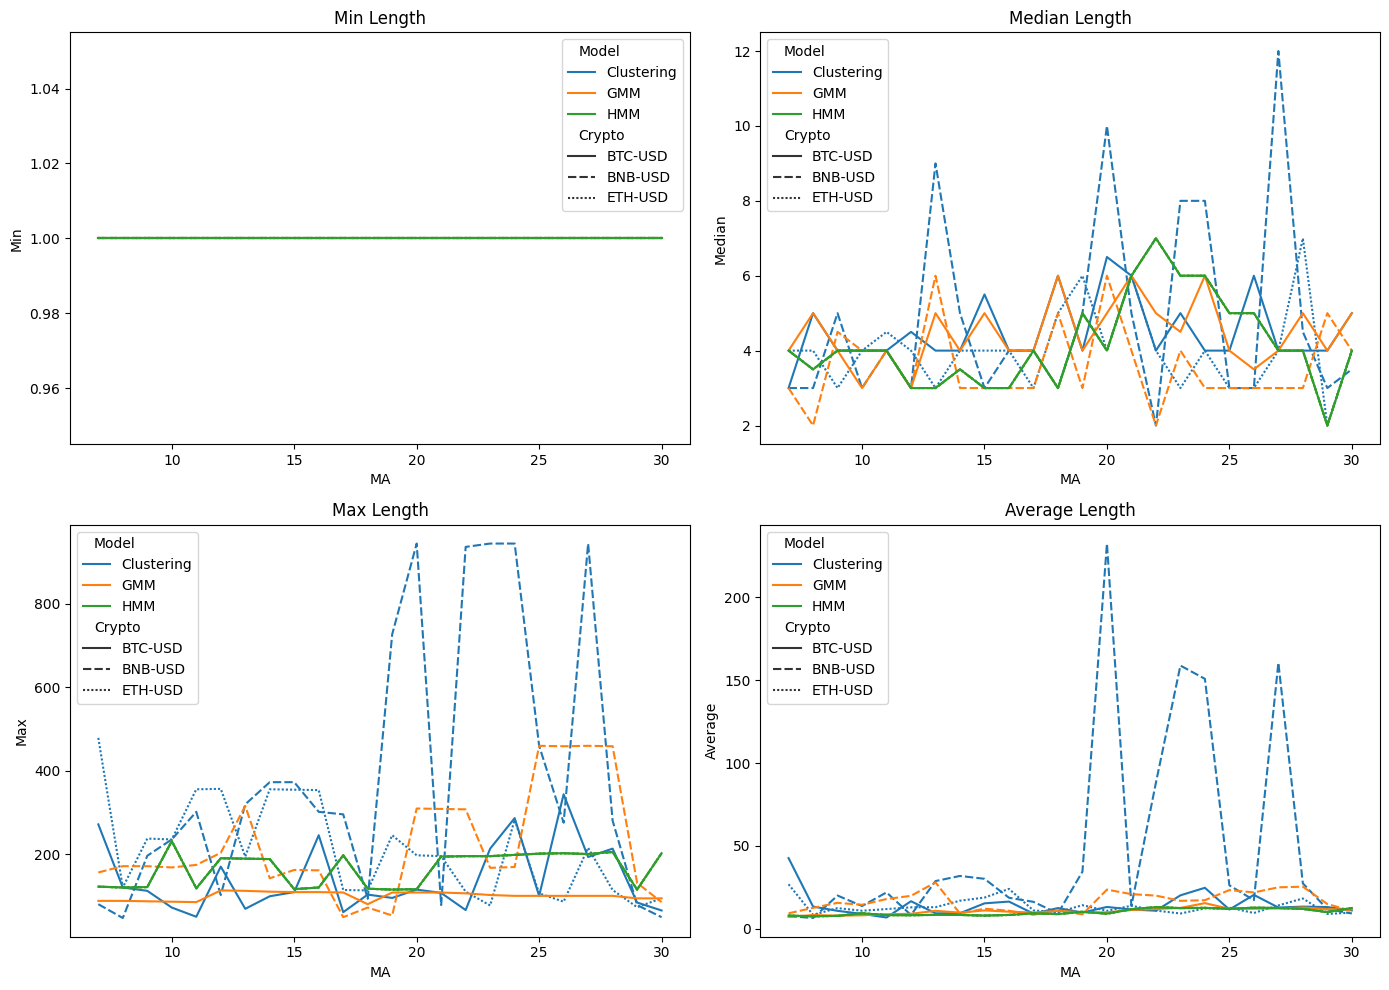

In [ ]:
# plot min, median, max, average MA, color by model, line type by crypto
df = pd.DataFrame({
    'MA': ma_,
    'Model': model_,
    'Min': min_,
    'Median': median_,
    'Max': max_,
    'Average': average_,
    'Crypto': crypto_
})

# Creating subplots for each metric

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Min
sns.lineplot(x='MA', y='Min', hue='Model', style='Crypto', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Min Length')

# Median
sns.lineplot(x='MA', y='Median', hue='Model', style='Crypto', data=df, ax=axs[0, 1])
axs[0, 1].set_title('Median Length')

# Max
sns.lineplot(x='MA', y='Max', hue='Model', style='Crypto', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Max Length')

# Average
sns.lineplot(x='MA', y='Average', hue='Model', style='Crypto', data=df, ax=axs[1, 1])
axs[1, 1].set_title('Average Length')

# Adjust layout
plt.tight_layout()
plt.show()

From the plot, we can see that taking moving average of 17 days, max and average length of regime segments are similar across models for BTC, BNB and ETH. For ETH, there are more fluctuation across the different MAs.

In [ ]:
assets = pd.concat([cryptos], axis=1)
assets = assets.dropna()

for crypto in cryptos:
  assets5 = prepare_data_for_model_input(assets, crypto, 5)
  assets10 = prepare_data_for_model_input(assets, crypto, 10)
  assets15 = prepare_data_for_model_input(assets, crypto, 15)
  assets18 = prepare_data_for_model_input(assets, crypto, 18)
  assets20 = prepare_data_for_model_input(assets, crypto, 20)
  assets25 = prepare_data_for_model_input(assets, crypto, 25)
  assets30 = prepare_data_for_model_input(assets, crypto, 30)


### Clustering, using the various multiple moving average of assets

In [ ]:
regime_detection = RegimeDetection()
# BTC
params = {'n_clusters': 3, 'linkage': 'complete', 'metric': 'manhattan', 'random_state':100}
clustering = regime_detection.get_regimes_clustering(params)
prices_array_BTC = np.array([[q] for q in assets30['BTC-USD_ma'].values])
clustering_states = clustering.fit_predict(prices_array_BTC)

plot_hidden_states(np.array(clustering_states), assets, 'BTC-USD', 'BTC-USD clustering')


Number of observations for State  0 : 1330
Number of observations for State  1 : 374
Number of observations for State  2 : 122


In [ ]:
#BNB
prices_array_BNB = np.array([[q] for q in assets30['BNB-USD_log_return'].values])
clustering = regime_detection.get_regimes_clustering(params)
clustering_states = clustering.fit_predict(prices_array_BNB)
plot_hidden_states(np.array(clustering_states), assets, 'BNB-USD', 'BNB-USD clustering')


Number of observations for State  0 : 1789
Number of observations for State  1 : 5
Number of observations for State  2 : 32


In [ ]:
#ETH
prices_array_ETH = np.array([[q] for q in assets30['ETH-USD_log_return'].values])
clustering = regime_detection.get_regimes_clustering(params)
clustering_states = clustering.fit_predict(prices_array_ETH)
plot_hidden_states(np.array(clustering_states), assets30, 'ETH-USD', 'ETH-USD clustering')

Number of observations for State  0 : 248
Number of observations for State  1 : 335
Number of observations for State  2 : 1243


### GMM

In [ ]:
# BTC
params = {'n_components':3, 'covariance_type': 'full', 'max_iter': 100000, 'n_init': 1000,'init_params': 'kmeans', 'random_state':100}
gmm_model = regime_detection.get_regimes_gmm(prices_array_BTC, params)
gmm_states = gmm_model.predict(prices_array_BTC)
plot_hidden_states(np.array(gmm_states), assets30, 'BTC-USD', 'BTC-USD GMM')


Number of observations for State  0 : 444
Number of observations for State  1 : 650
Number of observations for State  2 : 732


In [ ]:
# BNB
gmm_model = regime_detection.get_regimes_gmm(prices_array_BNB, params)
gmm_states = gmm_model.predict(prices_array_BNB)
plot_hidden_states(np.array(gmm_states), assets30, 'BNB-USD', 'BNB-USD GMM')


Number of observations for State  0 : 927
Number of observations for State  1 : 860
Number of observations for State  2 : 39


In [ ]:
# ETH
prices_array_ETH = np.array([[q] for q in assets30['ETH-USD_log_return'].values])
gmm_model = regime_detection.get_regimes_gmm(prices_array_ETH, params)
gmm_states = gmm_model.predict(prices_array_ETH)
plot_hidden_states(np.array(gmm_states), assets, 'ETH-USD', 'ETH-USD GMM')

Number of observations for State  0 : 489
Number of observations for State  1 : 190
Number of observations for State  2 : 1147


### HMM

In [ ]:
# BTC
params = {'n_components':3, 'covariance_type':"full", 'random_state':20}
hmm_model = regime_detection.get_regimes_hmm(prices_array_BTC, params)
hmm_states = hmm_model.predict(prices_array_BTC)
plot_hidden_states(np.array(hmm_states), assets18, 'BTC-USD', 'BTC-USD HMM')


Number of observations for State  0 : 735
Number of observations for State  1 : 492
Number of observations for State  2 : 599


In [ ]:
# BNB
hmm_model = regime_detection.get_regimes_hmm(prices_array_BNB, params)
hmm_states = hmm_model.predict(prices_array_BNB)
plot_hidden_states(np.array(hmm_states), assets, 'BNB-USD', 'BNB-USD HMM')



Number of observations for State  0 : 269
Number of observations for State  1 : 774
Number of observations for State  2 : 783


In [ ]:
# ETH
hmm_model = regime_detection.get_regimes_hmm(prices_array_ETH, params)
hmm_states = hmm_model.predict(prices_array_ETH)
plot_hidden_states(np.array(hmm_states), assets, 'ETH-USD', 'ETH-USD HMM')

Number of observations for State  0 : 317
Number of observations for State  1 : 750
Number of observations for State  2 : 759


# MSM Markov Switching Model

In [ ]:
# create dataframe for MSM from the base cryptos dataframe
data_msm = pd.concat([cryptos], axis=1).dropna()
returns = data_msm.pct_change(1).dropna()
returns

,BNB-USD,BTC-USD,ETH-USD
Date,,,
2017-11-10,-0.097415,-0.073554,-0.067411
2017-11-11,-0.070329,-0.039368,0.051555
2017-11-12,-0.090262,-0.064101,-0.021523
2017-11-13,0.109845,0.102422,0.028606
2017-11-14,-0.055757,0.011626,0.066037
...,...,...,...
2023-11-08,0.002955,0.005973,0.000635
2023-11-09,0.017755,0.029108,0.122392
2023-11-10,-0.001704,0.016920,-0.019934


In [ ]:
def compute_model_msm(data, crypto, iterations=5500):
  """ computing the MSM model for crypto, using 5500 iterations """
  data = data[crypto]
  print(f"Computing MSM model for {crypto}")
  data = data.dropna() # removing null for the endogenous data required for MarkovRegression
  model = sm.tsa.MarkovRegression(data, k_regimes=3, trend='c', switching_variance=True)
  return model, model.fit(iter=iterations) #running 5500 iterations for all the data points

In [ ]:
model_btc, model_result_btc = compute_model_msm(returns, 'BTC-USD')
model_eth, model_result_eth = compute_model_msm(returns, 'ETH-USD')
model_bnb, model_result_bnb = compute_model_msm(returns, 'BNB-USD')


Computing MSM model for BTC-USD
Computing MSM model for ETH-USD
Computing MSM model for BNB-USD


In [ ]:
model_result_btc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                BTC-USD   No. Observations:                 2194
Model:               MarkovRegression   Log Likelihood                4471.440
Date:                Mon, 15 Jan 2024   AIC                          -8918.880
Time:                        22:40:52   BIC                          -8850.558
Sample:                    11-10-2017   HQIC                         -8893.911
                         - 11-12-2023                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.257      0.797      -0.001       0.001
sigma2      9.535e-05   1.77e-05      5.383      0.000    6.06e-05       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.743      0.081      -0.000       0.005
sigma2         0.0012      0.000      9.864      0.000       0.001       0.001
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.582      0.560      -0.004       0.008
sigma2         0.0039      0.000     11.228      0.000       0.003       0.005
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.6621      0.050     13.220      0.000       0.564       0.760
p[1->0]        0.2424      0.055      4.436      0.000       0.135       0.349
p[2->0]     4.308e-05      0.051      0.001      0.999      -0.099       0.099
p[0->1]        0.3294      0.049      6.679      0.000       0.233       0.426
p[1->1]        0.7449      0.053     13.965      0.000       0.640       0.849
p[2->1]        0.0373      0.039      0.944      0.345      -0.040       0.115
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
model_result_eth.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                ETH-USD   No. Observations:                 2194
Model:               MarkovRegression   Log Likelihood                3862.990
Date:                Mon, 15 Jan 2024   AIC                          -7701.981
Time:                        22:40:52   BIC                          -7633.659
Sample:                    11-10-2017   HQIC                         -7677.012
                         - 11-12-2023                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.689      0.091      -0.004       0.000
sigma2         0.0002    4.1e-05      4.249      0.000    9.37e-05       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      2.876      0.004       0.001       0.006
sigma2         0.0013      0.000      6.586      0.000       0.001       0.002
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.004      0.148      0.882      -0.007       0.009
sigma2         0.0064      0.001      7.700      0.000       0.005       0.008
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8062      0.061     13.299      0.000       0.687       0.925
p[1->0]        0.0672      0.026      2.587      0.010       0.016       0.118
p[2->0]     2.074e-08        nan        nan        nan         nan         nan
p[0->1]        0.1519      0.054      2.817      0.005       0.046       0.258
p[1->1]        0.8718      0.029     30.364      0.000       0.816       0.928
p[2->1]        0.1873      0.062      3.032      0.002       0.066       0.308
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
model_result_bnb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                BNB-USD   No. Observations:                 2194
Model:               MarkovRegression   Log Likelihood                3845.394
Date:                Mon, 15 Jan 2024   AIC                          -7666.788
Time:                        22:40:52   BIC                          -7598.466
Sample:                    11-10-2017   HQIC                         -7641.819
                         - 11-12-2023                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.857      0.391      -0.001       0.002
sigma2         0.0004   5.24e-05      7.952      0.000       0.000       0.001
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.635      0.102      -0.001       0.006
sigma2         0.0025      0.000      7.977      0.000       0.002       0.003
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0348      0.018      1.954      0.051      -0.000       0.070
sigma2         0.0281      0.007      4.221      0.000       0.015       0.041
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9263   4.86e-05   1.91e+04      0.000       0.926       0.926
p[1->0]        0.0582      0.014      4.227      0.000       0.031       0.085
p[2->0]     6.722e-09        nan        nan        nan         nan         nan
p[0->1]        0.0737    1.6e-05   4614.578      0.000       0.074       0.074
p[1->1]        0.9160      0.016     57.002      0.000       0.885       0.948
p[2->1]        0.2319      0.096      2.412      0.016       0.043       0.420
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
def _calc_inner(model_result):
  """ helper method to extract the regime probabilities and the predicted regimes based off the model result """
  regime_probs = model_result.smoothed_marginal_probabilities
  predicted_regimes = model_result.predicted_marginal_probabilities.idxmax(axis=1)
  return regime_probs, predicted_regimes

def calc_regime_probs_and_prediction(model_result_btc, model_result_eth, model_result_bnb):
  """ extracting the regime probabilities and the predicted regimes for the 3 cryptos from the model results """
  computed_data = {}
  computed_data['BTC-USD'] = _calc_inner(model_result_btc)
  computed_data['ETH-USD'] = _calc_inner(model_result_eth)
  computed_data['BNB-USD'] = _calc_inner(model_result_bnb)
  return computed_data


In [ ]:
regime_probs_and_prediction = calc_regime_probs_and_prediction(model_result_btc, model_result_eth, model_result_bnb)
regime_probs_and_prediction

{'BTC-USD': (                       0         1         2
  Date                                        
  2017-11-10  1.309800e-13  0.020769  0.979231
  2017-11-11  4.562734e-06  0.012694  0.987301
  2017-11-12  7.843074e-12  0.004994  0.995006
  2017-11-13  1.598635e-25  0.001849  0.998151
  2017-11-14  3.692619e-04  0.003444  0.996187
  ...                  ...       ...       ...
  2023-11-08  6.503716e-01  0.348845  0.000783
  2023-11-09  9.215882e-02  0.906115  0.001726
  2023-11-10  3.916265e-01  0.606549  0.001824
  2023-11-11  7.417605e-01  0.255751  0.002489
  2023-11-12  7.832891e-01  0.211903  0.004808
  
  [2194 rows x 3 columns],
  Date
  2017-11-10    1
  2017-11-11    2
  2017-11-12    2
  2017-11-13    2
  2017-11-14    2
               ..
  2023-11-08    0
  2023-11-09    0
  2023-11-10    1
  2023-11-11    1
  2023-11-12    0
  Length: 2194, dtype: int64),
 'ETH-USD': (                       0         1         2
  Date                                        
  2017-

In [ ]:
def plot_predicted_regimes_msm(data, regime_probs_and_prediction, crypto):
  """ function to plot the predicted regime computed via MSM  """
  regime_probs_and_prediction = regime_probs_and_prediction[crypto]
  data = data[crypto]
  figure, axes = plt.subplots(2, figsize=(10, 8))

  predicted_regimes = regime_probs_and_prediction[1]
  color_map = {2: 'red', 1: 'green', 0: 'blue'}
  ax = axes[0]
  ax.plot(data.index, data, c="black")
  converted = [float(val) for val in predicted_regimes.values]
  new_value = np.interp(converted, [0, 2], [min(data), max(data)])
  ax.scatter(data.index, data, c=predicted_regimes.map(color_map), label='Predicted Regimes', marker='o')
  ax.set(title=f'Daily Chg % in {crypto} v/s Predicted regime')

  ax = axes[1]
  loc = data_msm[crypto][1:]
  ax.scatter(loc.index, loc, c=predicted_regimes.map(color_map), label='Predicted Regimes', marker='o')
  ax.set(title=f'Actual {crypto} v/s Predicted regime')

  plt.subplots_adjust(hspace=0.3)
  plt.show()

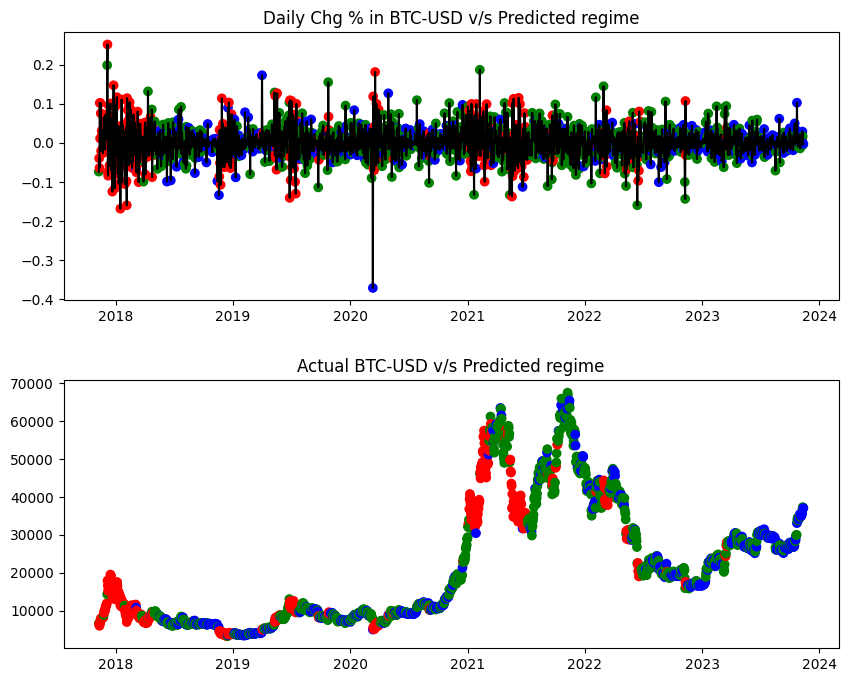

In [ ]:
plot_predicted_regimes_msm(returns, regime_probs_and_prediction, "BTC-USD")

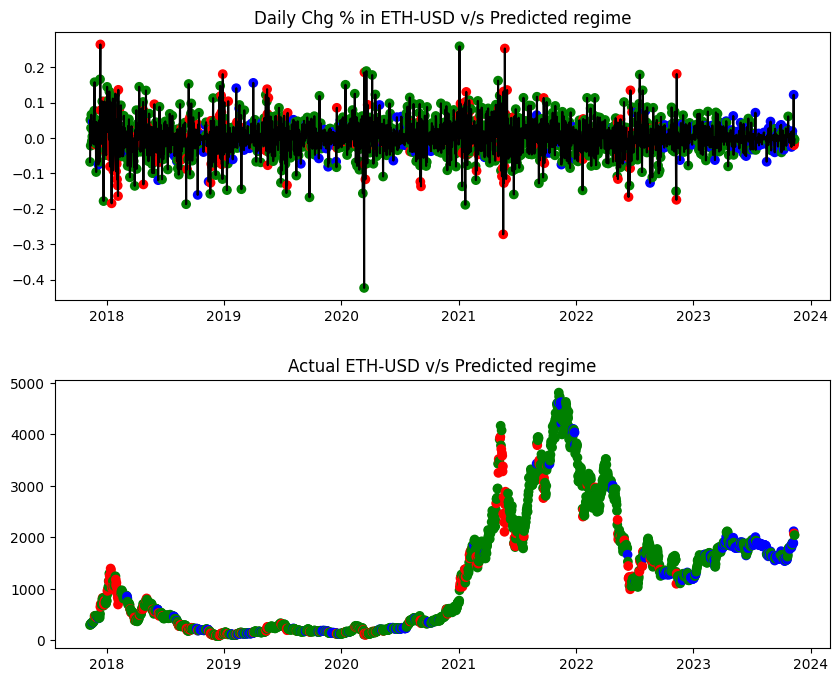

In [ ]:
plot_predicted_regimes_msm(returns, regime_probs_and_prediction, "ETH-USD")

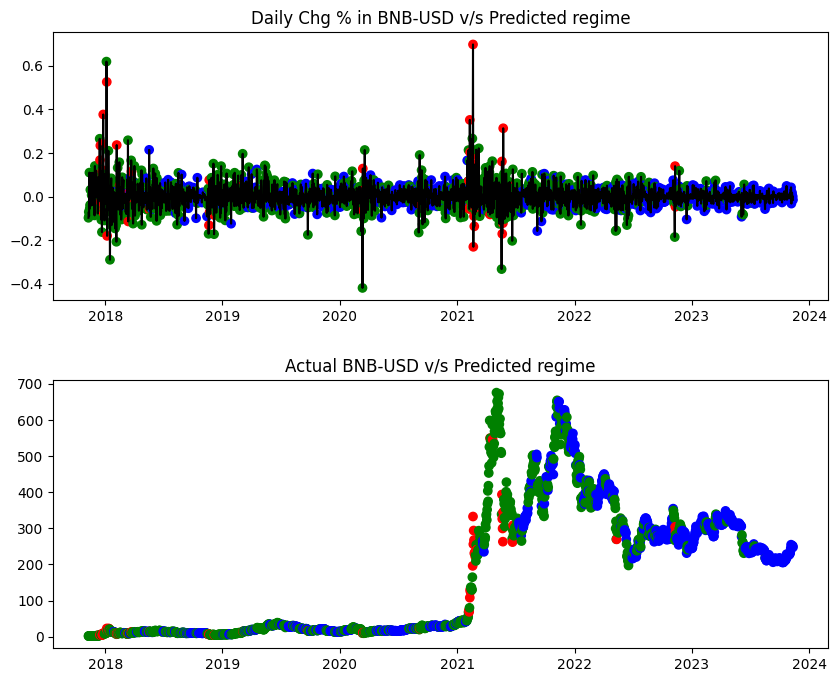

In [ ]:
plot_predicted_regimes_msm(returns, regime_probs_and_prediction, "BNB-USD")

## Variations to the models.

Of the four, HMM seems to seems to be capturing the patterns for BTC, but hardly for BNB and ETH. Therefore, we first experimented. a multivariate HMM model to jointly model the market regimes of all three cryptocurrency.

In [ ]:
np.random.seed(42)
n_samples = 100
# Create a multivariate HMM model
model = GaussianHMM(n_components=3, covariance_type="full")
model_data = assets30.iloc[:,[4, 6, 8]]

# Fit the model to the data
model.fit(model_data.values)
clustering_states = model.predict(model_data)

In [ ]:
plot_hidden_states(np.array(clustering_states), assets30, 'BTC-USD', 'BTC-USD HMM')
plot_hidden_states(np.array(clustering_states), assets30, 'BNB-USD', 'BNB-USD HMM')
plot_hidden_states(np.array(clustering_states), assets30, 'ETH-USD', 'ETH-USD HMM')

Number of observations for State  0 : 671
Number of observations for State  1 : 672
Number of observations for State  2 : 483


Number of observations for State  0 : 671
Number of observations for State  1 : 672
Number of observations for State  2 : 483


Number of observations for State  0 : 671
Number of observations for State  1 : 672
Number of observations for State  2 : 483


GMM also has the ability for modeling multiple time series together.

In [ ]:
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init = 5, init_params= 'kmeans', random_state = 100)

# Fit the model to the data
gmm.fit(model_data.values)

# Predict the component assignments
labels = gmm.predict(model_data.values)

In [ ]:
plot_hidden_states(np.array(labels), assets30, 'BTC-USD', 'BTC-USD HMM')
plot_hidden_states(np.array(labels), assets30, 'BNB-USD', 'BNB-USD HMM')
plot_hidden_states(np.array(labels), assets30, 'ETH-USD', 'ETH-USD HMM')

Number of observations for State  0 : 115
Number of observations for State  1 : 1465
Number of observations for State  2 : 246


Number of observations for State  0 : 115
Number of observations for State  1 : 1465
Number of observations for State  2 : 246


Number of observations for State  0 : 115
Number of observations for State  1 : 1465
Number of observations for State  2 : 246


On the other hand, based on the previous results, we also observed that the regimes on the pre-2021 period is more stable, whereas on the post-2021 period, the regimes are much shorter, involving single day changes. Therefore, we experimented with dividing the time series into before Oct 2020, Oct 2020 - June 2022 and post June-2022

In [ ]:
regime_detection = RegimeDetection()
params = {'n_components':3, 'covariance_type':"full", 'random_state':40}
# params = {'n_clusters': 3, 'linkage': 'complete', 'metric': 'manhattan', 'random_state':5}

assets_pre_2021 = assets.iloc[0:700,]
assets_pre2021_5 = prepare_data_for_model_input(assets_pre_2021, crypto, 8)
prices_array_BTC1 = np.array([[q] for q in assets_pre2021_5['BTC-USD_log_return'].values])
hmm_model1 = regime_detection.get_regimes_hmm(prices_array_BTC1, params)
BTC_regimes1 = hmm_model1.predict(prices_array_BTC1)
plot_hidden_states(BTC_regimes1, assets_pre_2021, 'BTC-USD', 'BTC-USD Regimes')

Number of observations for State  0 : 118
Number of observations for State  1 : 574


In [ ]:
regime_detection = RegimeDetection()
params = {'n_components':3, 'covariance_type':"full", 'random_state':5}
# params = {'n_clusters': 3, 'linkage': 'complete', 'metric': 'manhattan', 'random_state':5}

assets_2021_22 = assets.iloc[700:1250,]
assets_2021_22_5 = prepare_data_for_model_input(assets_2021_22, crypto, 30)
prices_array_BTC1 = np.array([[q] for q in assets_2021_22_5['BTC-USD_log_return'].values])
hmm_model1 = regime_detection.get_regimes_hmm(prices_array_BTC1, params)
BTC_regimes1 = hmm_model1.predict(prices_array_BTC1)
plot_hidden_states(BTC_regimes1, assets_2021_22, 'BTC-USD', 'BTC-USD Regimes')

Number of observations for State  0 : 292
Number of observations for State  1 : 228


In [ ]:
regime_detection = RegimeDetection()
params = {'n_components':3, 'covariance_type':"full", 'random_state':5}

assets_22 = assets.iloc[1250:,]
assets_22_5 = prepare_data_for_model_input(assets_22, crypto, 20)
prices_array_BTC1 = np.array([[q] for q in assets_22_5['BTC-USD_log_return'].values])
hmm_model1 = regime_detection.get_regimes_hmm(prices_array_BTC1, params)
BTC_regimes1 = hmm_model1.predict(prices_array_BTC1)
plot_hidden_states(BTC_regimes1, assets_22, 'BTC-USD', 'BTC-USD Regimes')

Number of observations for State  0 : 486
Number of observations for State  1 : 70


Log-Likelihood

In [ ]:
# GMM and HMM training (get_regimes_gmm, get_regimes_hmm)

# GMM Evaluation
gmm_model_btc = regime_detection.get_regimes_gmm(prices_array_BTC, params)
gmm_log_likelihood_btc = gmm_model_btc.score(prices_array_BTC)
print(f"GMM Log-Likelihood (BTC): {gmm_log_likelihood_btc}")

# HMM Evaluation
hmm_model_btc = regime_detection.get_regimes_hmm(prices_array_BTC, params)
hmm_log_likelihood_btc = hmm_model_btc.score(prices_array_BTC.reshape(-1, 1))
print(f"HMM Log-Likelihood (BTC): {hmm_log_likelihood_btc}")


GMM Log-Likelihood (BTC): -10.812819219747826
HMM Log-Likelihood (BTC): -17861.62726670873


In [ ]:
# BNB

# GMM Evaluation
gmm_model_bnb = regime_detection.get_regimes_gmm(prices_array_BNB, params)
gmm_log_likelihood_bnb = gmm_model_bnb.score(prices_array_BNB)
print(f"GMM Log-Likelihood (BNB): {gmm_log_likelihood_bnb}")

# HMM Evaluation
hmm_model_bnb = regime_detection.get_regimes_hmm(prices_array_BNB, params)
hmm_log_likelihood_bnb = hmm_model_bnb.score(prices_array_BNB.reshape(-1, 1))
print(f"HMM Log-Likelihood (BNB): {hmm_log_likelihood_bnb}")


GMM Log-Likelihood (BNB): 3.241399285585767


HMM Log-Likelihood (BNB): 6825.113928302808


In [ ]:
# ETH

# GMM Evaluation
gmm_model_eth = regime_detection.get_regimes_gmm(prices_array_ETH, params)
gmm_log_likelihood_eth = gmm_model_eth.score(prices_array_ETH)
print(f"GMM Log-Likelihood (ETH): {gmm_log_likelihood_eth}")

# HMM Evaluation
hmm_model_eth = regime_detection.get_regimes_hmm(prices_array_ETH, params)
hmm_log_likelihood_eth = hmm_model_eth.score(prices_array_ETH.reshape(-1, 1))
print(f"HMM Log-Likelihood (ETH): {hmm_log_likelihood_eth}")


GMM Log-Likelihood (ETH): 3.302530813969823
HMM Log-Likelihood (ETH): 6875.09748692746


In [ ]:
# plotting hidden states (plot_hidden_states)


# Plot GMM States
plot_hidden_states(np.array(gmm_states), assets, 'BTC-USD', 'BTC-USD GMM')

# Plot HMM States
plot_hidden_states(np.array(hmm_states), assets, 'BTC-USD', 'BTC-USD HMM')


Number of observations for State  0 : 489
Number of observations for State  1 : 190
Number of observations for State  2 : 1147


Number of observations for State  0 : 317
Number of observations for State  1 : 750
Number of observations for State  2 : 759


In [ ]:
# Compare Log-Likelihoods
if gmm_log_likelihood_btc > hmm_log_likelihood_btc:
    print("GMM has a higher log-likelihood for BTC.")
else:
    print("HMM has a higher log-likelihood for BTC.")

# Compare Log-Likelihoods for BNB
if gmm_log_likelihood_bnb > hmm_log_likelihood_bnb:
    print("GMM has a higher log-likelihood for BNB.")
else:
    print("HMM has a higher log-likelihood for BNB.")

# Compare Log-Likelihoods for ETH
if gmm_log_likelihood_eth > hmm_log_likelihood_eth:
    print("GMM has a higher log-likelihood for ETH.")
else:
    print("HMM has a higher log-likelihood for ETH.")

GMM has a higher log-likelihood for BTC.
HMM has a higher log-likelihood for BNB.
HMM has a higher log-likelihood for ETH.


As per log-likelihood comparisons, the Hidden Markov Model consistently provides a more accurate representation of market regimes across multiple cryptocurrencies, supporting its suitability for regime identification

Bayesian Information Criterion (BIC)

In [ ]:
# BTC
gmm_model_btc = regime_detection.get_regimes_gmm(prices_array_BTC, params)
bic_gmm_btc = gmm_model_btc.bic(prices_array_BTC)
hmm_model_btc = regime_detection.get_regimes_hmm(prices_array_BTC, params)
bic_hmm_btc = hmm_model_btc.bic(prices_array_BTC.reshape(-1, 1))

# BNB
gmm_model_bnb = regime_detection.get_regimes_gmm(prices_array_BNB, params)
bic_gmm_bnb = gmm_model_bnb.bic(prices_array_BNB)
hmm_model_bnb = regime_detection.get_regimes_hmm(prices_array_BNB, params)
bic_hmm_bnb = hmm_model_bnb.bic(prices_array_BNB.reshape(-1, 1))

# ETH
gmm_model_eth = regime_detection.get_regimes_gmm(prices_array_ETH, params)
bic_gmm_eth = gmm_model_eth.bic(prices_array_ETH)
hmm_model_eth = regime_detection.get_regimes_hmm(prices_array_ETH, params)
bic_hmm_eth = hmm_model_eth.bic(prices_array_ETH.reshape(-1, 1))

In [ ]:
# Compare BIC values
if bic_gmm_btc < bic_hmm_btc:
    print("GMM has a lower BIC for BTC.")
else:
    print("HMM has a lower BIC for BTC.")

if bic_gmm_bnb < bic_hmm_bnb:
    print("GMM has a lower BIC for BNB.")
else:
    print("HMM has a lower BIC for BNB.")

if bic_gmm_eth < bic_hmm_eth:
    print("GMM has a lower BIC for ETH.")
else:
    print("HMM has a lower BIC for ETH.")

HMM has a lower BIC for BTC.
HMM has a lower BIC for BNB.
HMM has a lower BIC for ETH.


BIC takes into account both the goodness of fit and the model complexity, providing a balance between these factors. Lower BIC values indicate a better trade-off between model fit and complexity. Hence in this case, HMM is a better fit.

## References

Reference papers (OpenAI. “Chow Test Detects Breaks”. ChatGPT3.5, https://chat.openai.com/c/c2407724-b67f-4c68-908b-76985d2d637a, Accessed 31 Oct. 2023.)
-

Gregory C. Chow's Original Paper:

Chow, G. C. (1960). "Tests of Equality Between Sets of Coefficients in Two Linear Regressions." Econometrica, 28(3), 591-605.
Introductory Papers and Texts:

Greene, W. H. (2003). "Econometric Analysis." Prentice Hall.
Gujarati, D. N. (2003). "Basic Econometrics." McGraw-Hill Education.
Advanced Texts and Journals:

Bai, J., & Perron, P. (1998). "Estimating and Testing Linear Models with Multiple Structural Changes." Econometrica, 66(1), 47-78.
Zivot, E., & Andrews, D. W. (1992). "Further Evidence on the Great Crash, the Oil-Price Shock, and the Unit-Root Hypothesis." Journal of Business & Economic Statistics, 10(3), 251-270.
Time Series Analysis and Econometrics:

Hamilton, J. D. (1994). "Time Series Analysis." Princeton University Press.
Enders, W. (2014). "Applied Econometric Time Series." Wiley.